In [203]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib as mpl
sns.set_style('darkgrid')
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

from typing import List
from collections import Counter
from collections import defaultdict

#####################################

from scipy.integrate import solve_ivp

# The SIR model

We will focus on the SIR model, probably the most studied model in computational epidemics. In its simplest form, the SIR model can be defined as follows. A large population of $N$ individuals is divided into three classes:
+ **Susceptible** individuals (S): those who do not have the disease but can get it.
+ **Infected** individuals (I) : those who have the disease.
+ **Recovered** individuals (R): those who cannot get the disease anymore.

The basic dynamics of the model are simple as well:
1. Susceptible individuals might get infected if they are in contact with an infected individual.
2. Infected individuals become recovered after some time.

Notice that individuals can only go from *S* to *I* and from *I* to *R*. We will also assume that infective individuals have contacts with randomly chosen individuals of all states at an average rate $\beta$ per unit time, and recover and acquire immunity (or die) at an average rate $\gamma$ per unit time.


### Fully mixed population
If we assume a very large population that is **fully mixed**, then the model can be descrived by a set of coupled nonlinear differential equations:  


<img src="attachment:image.png" width="400">

### Exercise 5.1
The `scipy.integrate` library has a function `solve_ip` that can be used to solve initial value problems for systems of ODES.
The documentation can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html).



Read the documentation and try to understand how to use `solve_ivp`. The key bit is to notice that we have to write a **function** `f(t, y)`  whose first argument is the timepoint `t` and whose second argument `y` is a numpy array. In our case, y will have dimension 3. Do you see why?


The Initial Value Problem to be solved is then simply

```text
    dy / dt = f(t, y)
    y(t0) = y0
```


Write a function `ode_SIR` that represents the system of differential equations of a SIR model and follows the specification of `solve_ivp`.

In [204]:
def odes_SIR(t, y):
    """
    The main ODE equations of the SIR model
    """
    S, I, R = y[0], y[1], y[2]
    N = S + I + R
    f=np.array([
        - (beta * (I/N) * S) ,
        (beta * (I/N) * S) - (gamma * I) ,
        (gamma * I)
    ])
    return f


### Exercise 5.2
Use `solve_ivp` and your `ode_SIR` function to study the behaviour of the SIR model for different values of the parameters, and describe your findings with a short paragraph.

In [157]:
# set parameters
beta=0.75
gamma=0.5
y0 = (1297, 3, 0)
tmax = 100
#parameters kind of randomly chosen
#N=1300

In [205]:
# solve ODE
t0=0
ode_result = solve_ivp(odes_SIR,(t0,tmax),y0=y0)

In [159]:
# extract results
assert ode_result.success
t_range = ode_result.t
S, I, R = ode_result.y

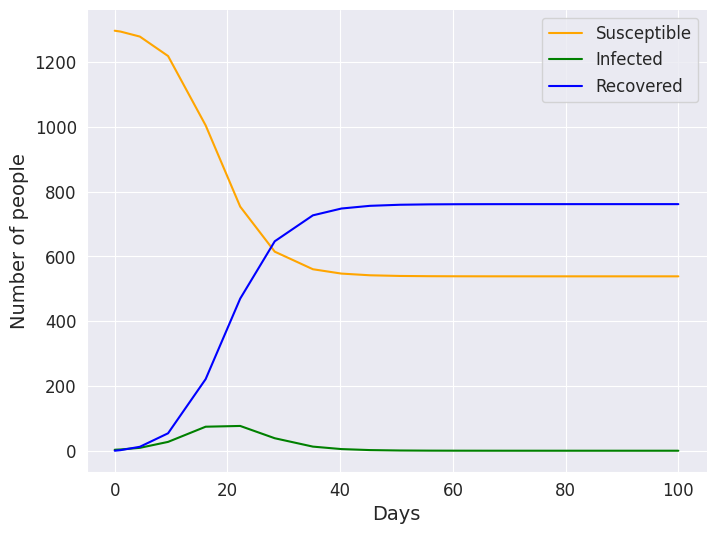

In [252]:
# OPTIONAL to get the same colors for S, I, R plots over all the notebook,
#we can define a dictionary of colors

SIR_colors = {
    "S": "orange",
    "I": "green",
    "R": "blue"
}

# plot solution (S, I, R) on y axis, time on x-axis
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(
    t_range,
    S,
    label="Susceptible",
    color=SIR_colors["S"]
)

ax.plot(
    t_range,
    I,
    label="Infected",
    color=SIR_colors["I"]
)

ax.plot(
    t_range,
    R,
    label="Recovered",
    color=SIR_colors["R"]
)
ax.set_xlabel('Days')
ax.set_ylabel('Number of people')
ax.legend(frameon=True)

Given the high infection rate $\beta$, the susceptible individuals decrease rapidly until they reach a certain minimum value, clearly such that $S_{eq} \geq 0$. Since an infected individual cannot revert to being susceptible, their behavior can only be strictly decreasing (until $\frac{\partial S}{\partial t} = 0$ for $t \geq t_1$). In this case, we can assume $t_1 \approx 15$.

The shape of the curve for the infected individuals is closely linked to the relationship between the parameter $\beta$ and the parameter $\gamma$. In the given example, with the former being high and the latter being lower, the curve of infected individuals grows initially while there is still a significant number of susceptibles, and then decreases until it reaches 0 for $t \geq t_2$. In this case, we can assume $t_2 \approx 60$.

As recovered individuals cannot be infected again, their behavior over time is represented by a strictly increasing function (until$\frac{\partial R}{\partial t} = 0$ for $t \geq t_2$).

### SIR model on a network
The ODE approximation of the SIR model is not very realistic because it assumes a fully mixed population.
The fact that we do not interact randomly with one another, but rather have complex social structures, schools, commuting etc is what makes the whole thing much more difficult.

To explorer the importance of the **contact network** for the spread of a disease, we will implement a simple discrete-time SIR model that runs on an arbitrary network or graph. To do so, we will define a class `SIRonGraph` that holds together the **graph** where the SIR model runs and the **methods** (aka functions) that implement the SIR dynamics.

We will use the `networkx` module, a well-known python library to work with networks data. To check if you have it installed in your computer, run

In [208]:
import networkx as nx

If you get a `ModuleNotFoundError`, that means that you need to install it before continuing. In most cases, simply opening a terminal and running

```bash
> pip install networkx
```

should work. Additional installation instructions can be found [here](https://networkx.org/documentation/stable/install.html).

Networkx provides you the `Graph` type, that is, a kind of variable that represents a graph or network. Let us try it:

In [209]:
G = nx.Graph()

Networks have nodes and edges. Let us add some. Here we use letters to label the nodes, but integers would work as well.

In [210]:
G.add_nodes_from(["A", "B", "C", "D", "E"])

In [211]:
G.add_edges_from([("A", "B"), ("B", "C"), ("C", "A"), ("C", "D"), ("E", "C")])

Now we want to have a look at our network. Networkx gives us some handy functions!

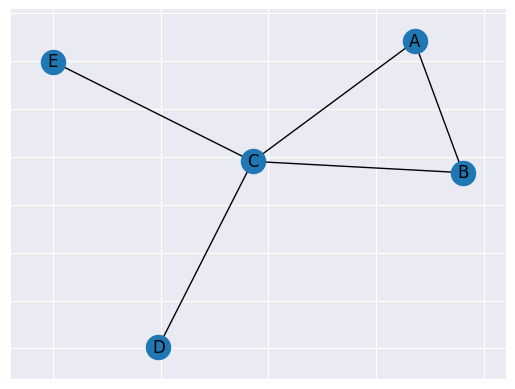

In [212]:
nx.draw_networkx(G)

Finally, networks can also hold some data on their nodes on edges. These are called **attributes** and are very useful. Let us create one:

In [213]:
initial_status = {
    "A": "S",
    "B": "S",
    "C": "I",
    "D": "S"
}

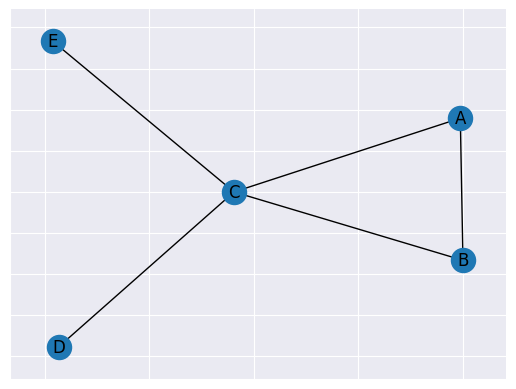

In [214]:
nx.draw_networkx(G)

In [215]:
initial_status

{'A': 'S', 'B': 'S', 'C': 'I', 'D': 'S'}

In [216]:
nx.set_node_attributes(G, initial_status, name="kind")

Now G carries the attribute *kind* with it. We can get the values of attributes of individual nodes easily:

In [217]:
G.nodes["C"]["kind"]

'I'

In [218]:
G.nodes["A"]["kind"]

'S'

We can also modify the value of an attribute. Let us suppose node C infects node B. The we could do:

In [219]:
if G.nodes["A"]["kind"]=="S" :
    print ("S")
    G.nodes["A"]["kind"]="I"
    print (G.nodes["A"]["kind"])
else :
    print ("none")

S
I


In [220]:
G.nodes["B"]["kind"] = "S"

If we need to get the attribute of all nodes, we can do it at once as follows:

In [221]:
current_status = nx.get_node_attributes(G, "kind")

In [222]:
current_status

{'A': 'I', 'B': 'S', 'C': 'I', 'D': 'S'}

### The SIR model as a python class

We will now create a class `SIRonGraph` to represent a SIR model on an arbitrary network. A class holds together data and functions (callled methods), and is exactly what we need in this case: a network and some functions that implement the SIR dynamics on it.

Classes can be a bit confusing at the beginning, but all you need to understand is that `self` means literary 'myself', that is, methods (functions) get as first argument the object they are acting on. This means that we can "store" a variable in one method and "retrieve" it in another! No need to pass it around!

Look at the following example code and play with it to make sure you understand how `self` works.

In [223]:
class Model:
    # this is a special method that gets called when you create an instance of your class
    def __init__(self, name):
        self.name = name

    def set_x(self, x):
        self.x = x

    def increment_x(self):
        self.x += 1

    def show_x(self):
        return self.x


In [224]:
model1 = Model(name="my first model")
model2 = Model(name="another model")

In [225]:
model1.set_x(3)
model2.set_x(-2)

In [226]:
model1.increment_x()

In [227]:
model1.show_x()

4

In [228]:
model2.show_x()

-2

We can also access information stored in our objects. Notice that our models had a name that was set at initialization.

In [229]:
model1.name

'my first model'

So, let us go back to our SIR model. The input to create a new SIR model on an arbitrary network is the following:

1. The graph onto which we want to run the SIR model.
2. A list of initially infected nodes.
3. The coefficient $\beta$
4. The coefficient $\gamma$

So, we create a class `SIRonGraph` that, when initialized, simply stores the input.

In [230]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """
        Initialize a SIR model on a network.
        """
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma
        self.init_inf = initial_infected

Let us try it. First we need to create a graph! Networkx has some functions to generate standard graphs. We could start with a lattice graph, for instance.

In [231]:
# 2 rows, 3 columns
G = nx.hexagonal_lattice_graph(m=2, n=3)

Notice that nodes are labelled with a tuple of integers `(col, row)` and that `G` comes with a nice `pos` node attribute, which we can use to nicely plot the network.

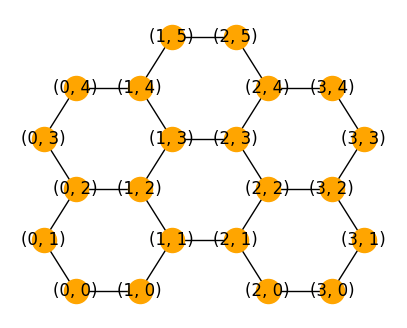

In [232]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_aspect(aspect="auto", anchor = "C")
ax.set_axis_off()

pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx(G, pos=pos, node_color='orange', with_labels=True)

Now we can create our first model

In [233]:
model = SIRonGraph(network=G, beta=0.3, gamma=0.1, initial_infected=[(1, 3)])

Notice that you can retrieve all the information that is stored in `self`.

In [187]:
model.network

Notice that `model.network` is not a copy of `G`: it is exactly the same object, point to the same memory address!

In [234]:
G

In [235]:
model.beta

0.3

In [190]:
model.gamma

0.1

In [236]:
model.init_inf

[(1, 3)]

### Exercise 5.3
Our model should do a few more things at initialization:
1. Checking that $\beta$ and $\gamma$ have sensible values.
2. Making sure that all elements in input list of inital infected are really nodes of the network.
3. Creating a node attribute called "kind" with value "S" for all nodes except for those in the list of `inital_infected`
Extend the SIRonGraph code below and implement points 1 and 2 in the ``__init__`` method.

In [237]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network.
        All nodes are set to S except those passed in the initial_infected list.
        """
        # make sure node in initial_infected list are really nodes of the network.
        # make sure node in initial_infected list are really nodes of the network.
        assert ( all(item in network.nodes for item in initial_infected))

        # set initial status of nodes as node att
        for n in range(len(network.nodes)):
            if list(network.nodes)[n] in initial_infected:
                initial_status = {
                    list(network.nodes)[n] : "I"
                }
            else:
                initial_status = {
                    list(network.nodes)[n] : "S"
                }
            nx.set_node_attributes(network, initial_status, name="kind")

        # make sure params make sense
        assert (1>gamma>0)
        assert (1>beta>0)

        # store parameters

        self.network = network
        self.beta = beta
        self.gamma = gamma

### Exercise 5.4
1. Create a function to visualize a hexagonal lattice model, with nodes colored by type. Your function should take as input the model instance (object of kind SIRonGraph) and display the network, coloring S, I and R nodes with different colors.
2. Show that your function works for a few examples with different input graph sizes and different sets of initially infected nodes.

**Tip**: look into the networkx documentation! It is [here](https://networkx.org/documentation/stable/reference/drawing.html).

In [238]:
def show_hex_model(model, ax=None):
    # creates a figure if no axis was passed
    ax_was_none = ax is None
    if ax_was_none:
        # create a figure
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.set_aspect(1)
        ax.set_axis_off()

    # get the positions and kind of nodes
    nodes=list(model.network.nodes)
    pos = nx.get_node_attributes(model.network, 'pos')
    kinds=nx.get_node_attributes(model.network, 'kind')

    # prepare a list of colors for the nodes using the kinds dict
    colors=[]
    for i in range(0,len(nodes)):

        if kinds[nodes[i]]=='S':
            colors.append("blue")

        if kinds[nodes[i]]=='I':
            colors.append("red")

        if kinds[nodes[i]]=='R':
            colors.append("green")

    # prepare a list of colors for the nodes using the kinds dict
    nx.draw_networkx(model.network,pos=pos,node_color=colors,ax=ax,with_labels=True, font_size=6, font_color='white')

    # returns the new figure if it was created here
    if ax_was_none:
        return fig, ax

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

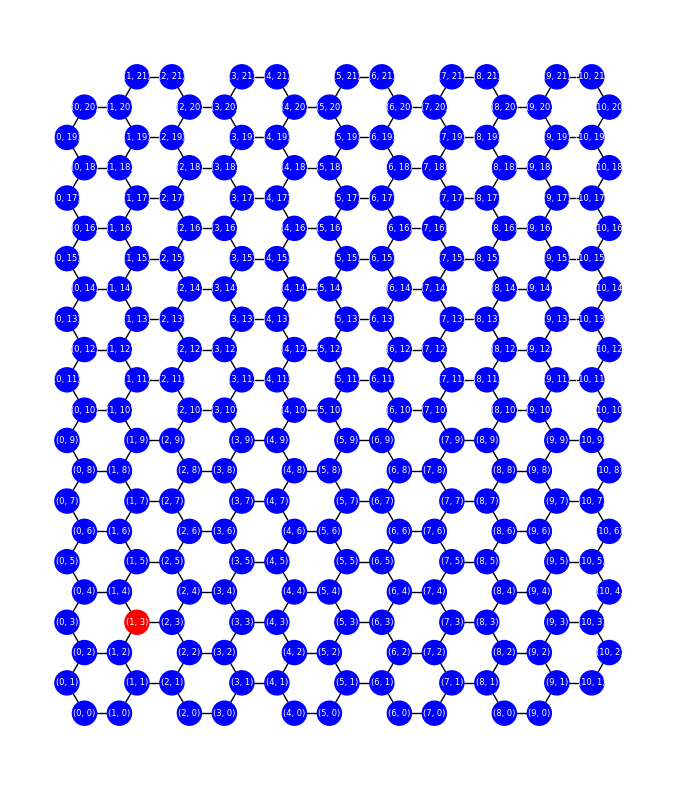

In [239]:
G = nx.hexagonal_lattice_graph(10, 10)
model = SIRonGraph(network=G, beta=0.3, gamma=0.1, initial_infected=[(1, 3)])
show_hex_model(model)

### SIR dynamics as class methods
Now we want to be able to run the SIR dynamics on our `SIRonGraph` objects. To simplify things, we  consider **discrete time** simulation, so that at each time-step:
+ Infected individuals have a chance to recover, and they do so with probability $\gamma$.
+ Susceptible individuals can be infected by any of the infected individuals to which they are connected. This happens with probability $\beta$ for each S-I edge.

### Exercise 5.5
Implement the dynamics of the SIR model as methods of your `SIRonGraph` class. You might want to implement two methods separately, as follows:

+ `_step(self)`: this method implements one single time-step, as descrived above.
+ `run(self, num_timesteps: int)`: this method (for now) simply calls `_step` repeatedly.

You will see, in a while, that it is useful to organize things as we are doing.

In [240]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network.
        All nodes are set to S except those passed in the initial_infected list.
        """
        # make sure node in initial_infected list are really nodes of the network.
        # make sure node in initial_infected list are really nodes of the network.
        assert ( all(item in network.nodes for item in initial_infected))

        # set initial status of nodes as node att
        nodes=list(network.nodes)

        for n in range(len(network.nodes)):

            if list(network.nodes)[n] in initial_infected:
                initial_status = {
                    list(network.nodes)[n] : "I"
                }
            else:
                initial_status = {
                    list(network.nodes)[n] : "S"
                }
            nx.set_node_attributes(network, initial_status, name="kind")

        # make sure params make sense
        assert (1>gamma>0)
        assert (1>beta>0)

        # store parameters

        self.network = network
        self.beta = beta
        self.gamma = gamma


    def run(self, num_timesteps: int):
        """Run SIR dynamics for num_timsteps steps"""
        for _ in range(num_timesteps):
            self._step()

    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        node=list(self.network.nodes)
        kinds=nx.get_node_attributes(self.network, 'kind')
        for i in range(len(node)):
            if kinds[node[i]] == "I":
                if np.random.uniform()< self.gamma:
                    kinds[node[i]]="R"

        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)

        edges=list(model.network.edges)

        for k in range(len(edges)):
            for i in range(2):
                if kinds[edges[k][i]]=="I" and kinds[edges[k][(i+1)%2]] == "S":
                    if np.random.uniform()< self.beta:
                        kinds[edges[k][(i+1)%2]] = "I"
        nx.set_node_attributes(self.network,kinds,name="kind")

### Exercise 5.6
Use your visualization function to show the evolution of a SIR model running in a hex lattice. You should decide the system size, number of timesteps and other parameterrs wisely to show that your code works properly.

In [241]:
G = nx.hexagonal_lattice_graph(10, 10)
model = SIRonGraph(network=G, beta=0.3, gamma=0.1, initial_infected=[(1, 3),(3,5)])

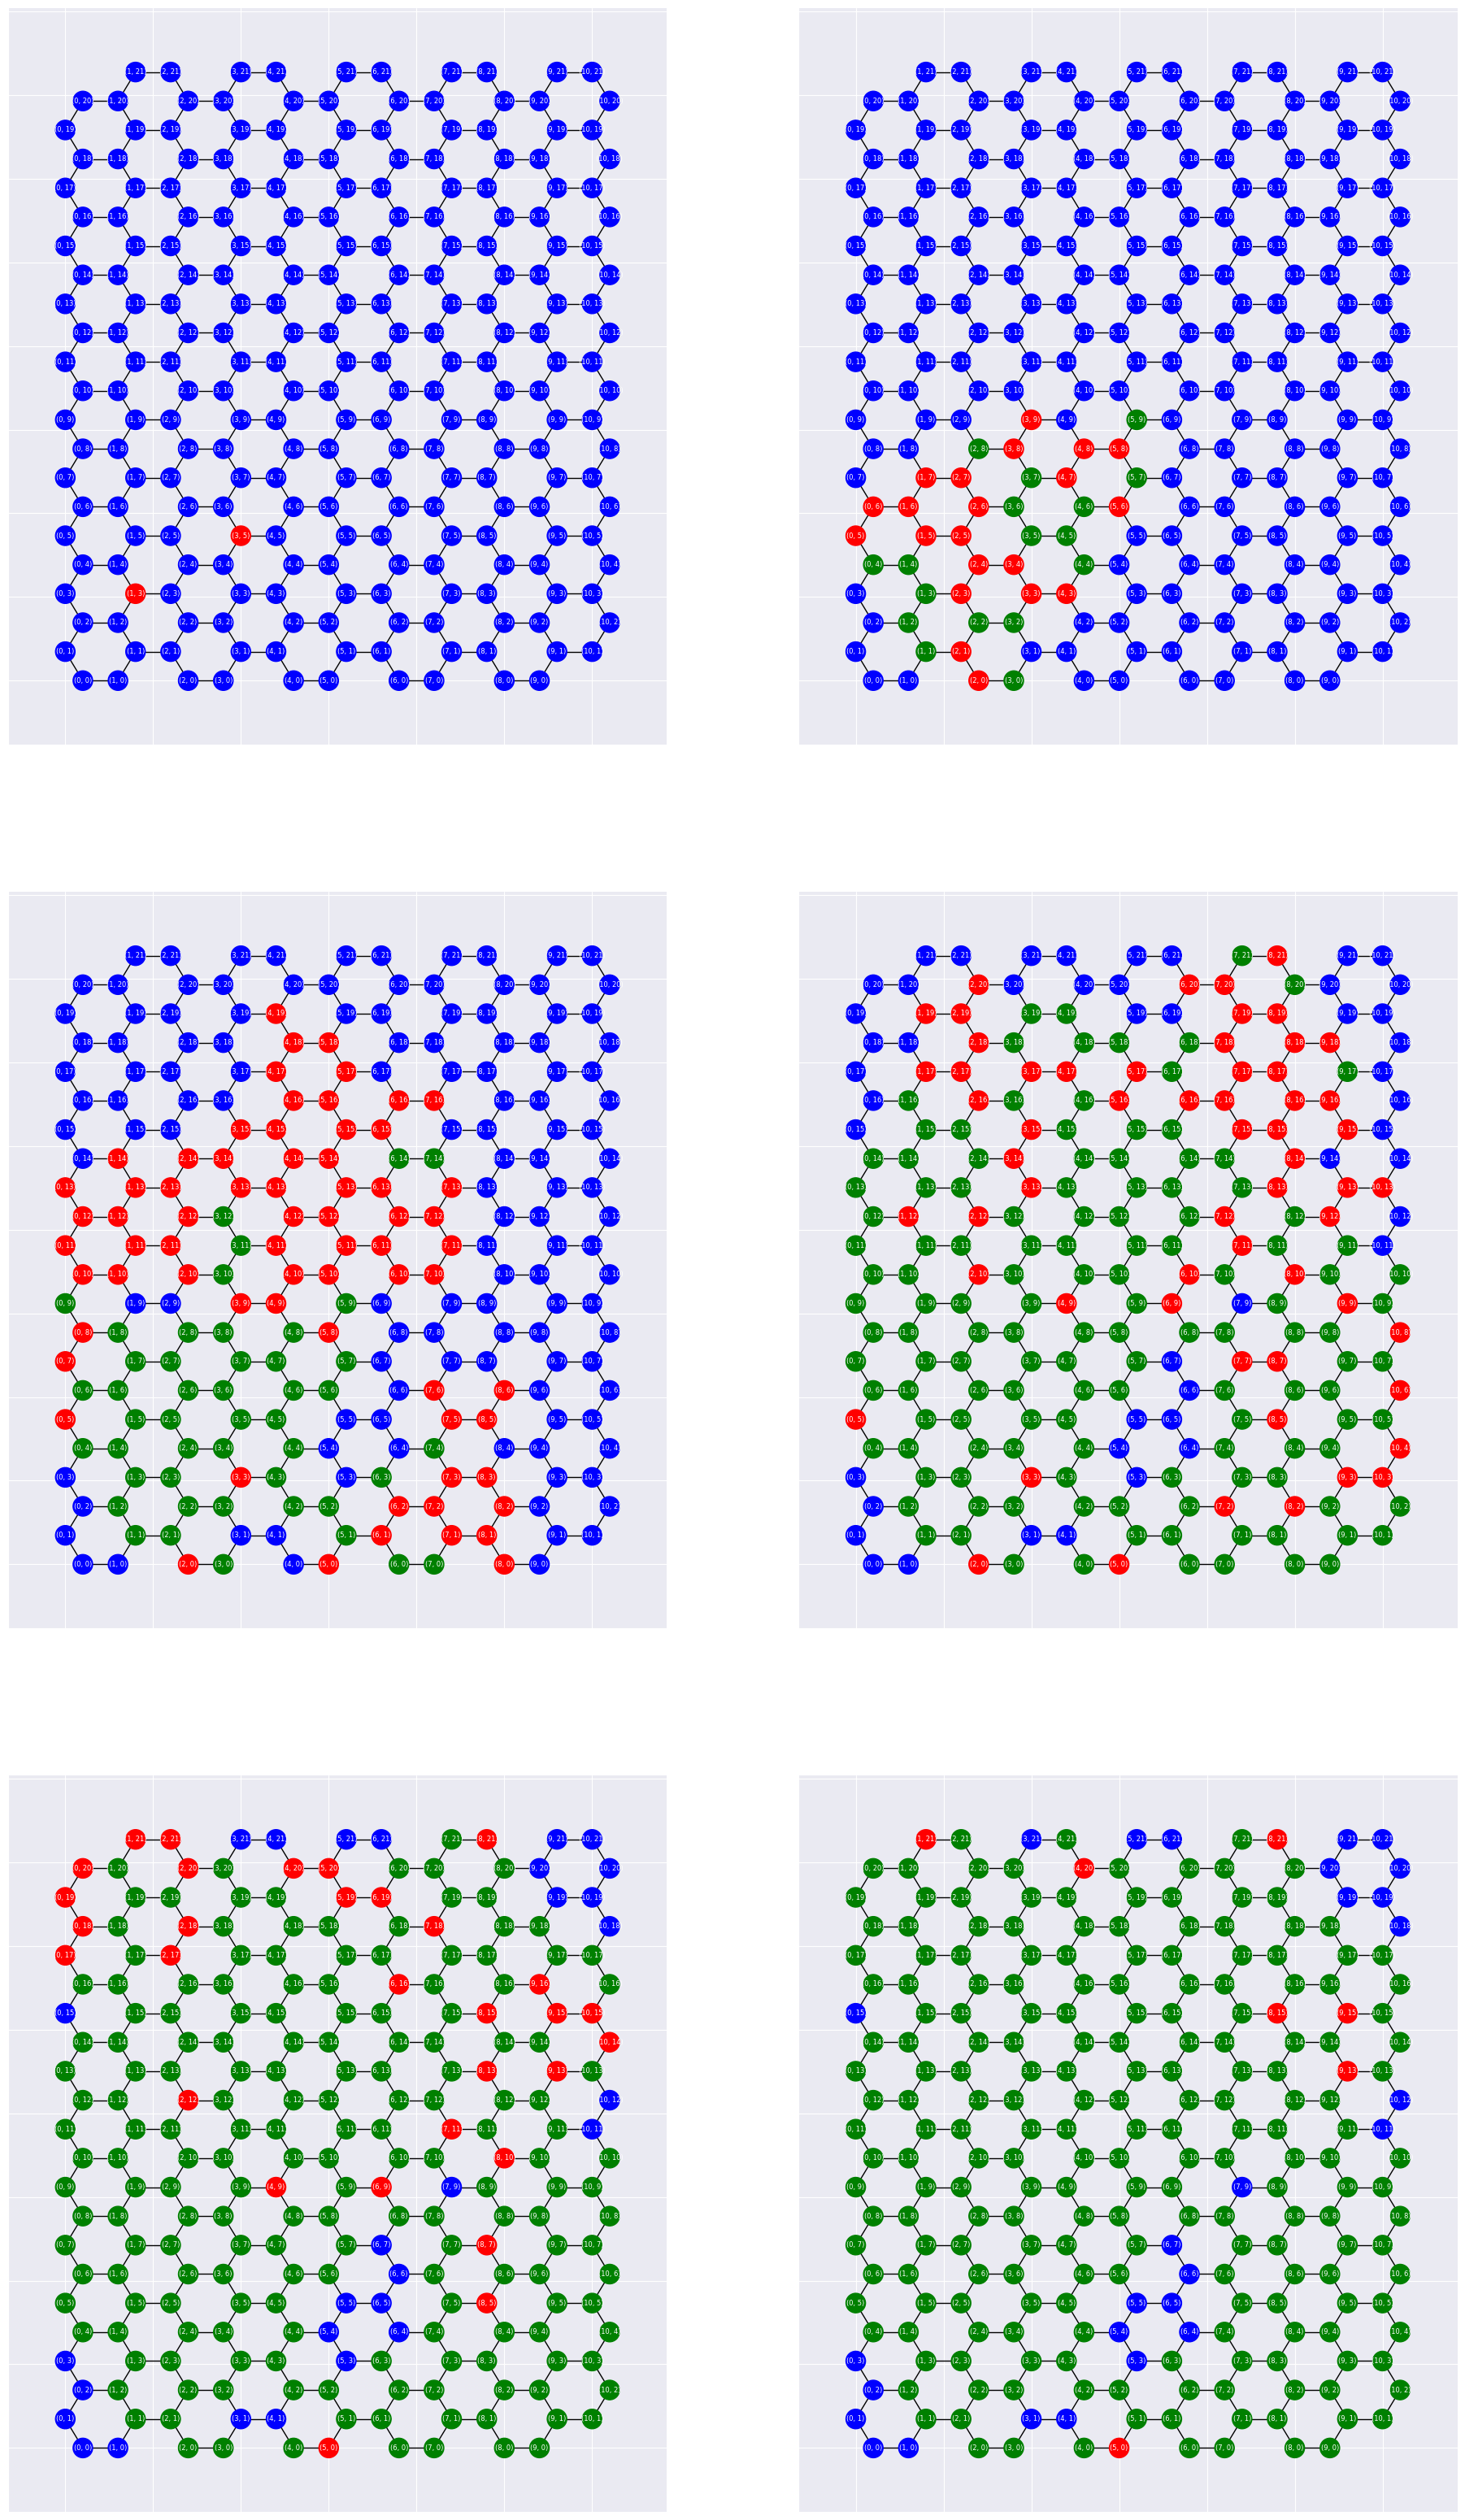

In [242]:
fig, axx = plt.subplots(3, 2, figsize=(23, 40))
axx = axx.reshape(-1)

for ax in axx:
    ### plot model status on axis ax
    show_hex_model(model,ax)

    ### run the model for some timesteps
    model.run(10)

### Storing SIR evolution as a class attribute
Now our class can run the SIR dynamics, but it doesn't "remember" the whole evolution of the simulation: only the final state is available. One way of storing some quantities of interest during the simulation is as follows:

1. Create an empty list at initialization.
```python
class SIRonGraph:
     def __init__(self, G: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
         ...
         # empty list, we will add info durring the simulation
         self.history = []
         ...
```

2. Create a _log() method that, when called, computes the information we want to store and adds it to the self.history list.

```python
   def _log(self):
        # do computations
        var1 = ...
        var2 = ...
        ...
        
        # create a block of info as list
        info = [var1, var2, ...]
        # or as a dict
        info = {
            "var1": var1,
            "var2": var2,
            ...
        }
        # or using any other scheme you like
        info = ...
        
        # add the info block to the history log
        self.history.append(info)
```

3. Call the ._log() method every time you want to store the variables of interest. That could be at every timestep or once in a while only.
It is also wise to call `._log()` once at initialization, to store the initial status.
```python
   def __init__(self, ...):
         ...
         self._log()
        
   def run(self, num_timesteps: int):
         """Run the SIR dynamics for some time."""
         ...
         for _ in range(num_timesteps):
              self._step()
              self._log()
         ...
```

### Exercise 5.7
1. Modify your SIRonGraph class so that it stores the number of **S**, **I** and **R** individuals at each timestep.
2. Simulate the SIR model in a network of your choice, and plot the evolution of the system (S, I, R) over time. Try to choose the parameters wisely, so that a typical epidemic wave can be seen.

In [243]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network.
        All nodes are set to S except those passed in the initial_infected list.
        """
        # make sure node in initial_infected list are really nodes of the network.
        assert ( all(item in network.nodes for item in initial_infected))

        # set initial status of nodes as node att
        nodes=list(network.nodes)

        for n in range(len(network.nodes)):

            if list(network.nodes)[n] in initial_infected:
                initial_status = {
                    list(network.nodes)[n] : "I"
                }
            else:
                initial_status = {
                    list(network.nodes)[n] : "S"
                }
            nx.set_node_attributes(network, initial_status, name="kind")

        # make sure params make sense
        assert (1>gamma>0)
        assert (1>beta>0)

        # store parameters

        self.network = network
        self.beta = beta
        self.gamma = gamma
        self.history=[]
        # store info of initial condition
        self._log()
        print(self.history)


    def run(self, num_timesteps: int):
        """Run SIR dynamics for num_timsteps steps"""
        for _ in range(num_timesteps):
            self._step()
            self._log()

    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        node=list(self.network.nodes)
        kinds=nx.get_node_attributes(self.network, 'kind')
        for i in range(len(node)):
            if kinds[node[i]] == "I":
                if np.random.uniform()< self.gamma:
                    kinds[node[i]]="R"

        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)

        edges=list(self.network.edges)

        for k in range(len(edges)):
            for i in range(2):
                if kinds[edges[k][i]]=="I" and kinds[edges[k][(i+1)%2]] == "S":
                    if np.random.uniform()< self.beta:
                        kinds[edges[k][(i+1)%2]] = "I"
        nx.set_node_attributes(self.network,kinds,name="kind")

    def _log(self):

        node=list(self.network.nodes)
        kinds=nx.get_node_attributes(self.network, 'kind')

        [n_infected,n_susceptible,n_recovered]=[0,0,0]

        for i in range(len(node)):

            if kinds[node[i]] == "I":
                n_infected+=1

            if kinds[node[i]] == "S":
                n_susceptible+=1

            if kinds[node[i]] == "R":
                n_recovered+=1

        info=[n_infected,n_susceptible,n_recovered]

        self.history.append(info)

In [244]:
# create the model
model = SIRonGraph(
    network=nx.hexagonal_lattice_graph(30, 20),
    initial_infected=[(10, 10), (2, 2), (2, 5)],
    beta=0.75,
    gamma=0.5
)

[[3, 1297, 0]]


In [245]:
# run the model for some time
running_time = 100
model.run(running_time)

In [246]:
# extract evolution of S, I, R from model.history
infected=[]
susceptibles=[]
recovered=[]
for i in range(0,running_time):
    infected.append(model.history[i][0])
    susceptibles.append(model.history[i][1])
    recovered.append(model.history[i][2])

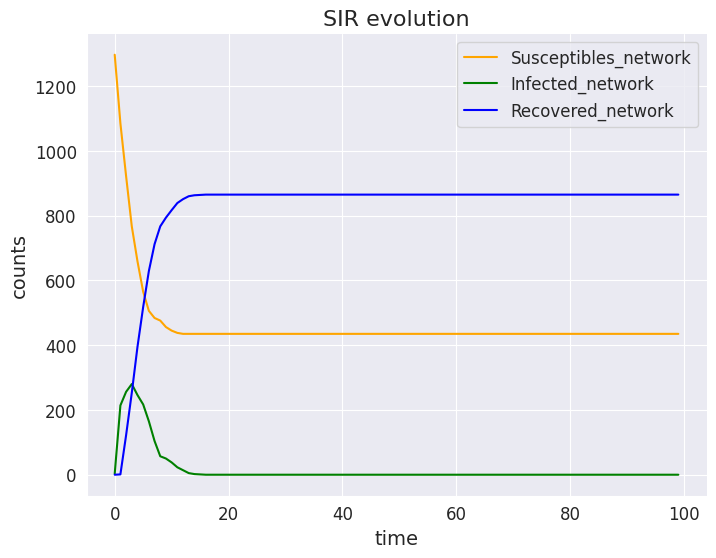

In [251]:
# plot S,I,R vs time

SIR_colors = {
    "S": "orange",
    "I": "green",
    "R": "blue"
}

# plot solution (S, I, R) on y axis, time on x-axis
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(susceptibles,label="Susceptibles_network",color="orange")
ax.plot(infected,label="Infected_network",color="green")
ax.plot(recovered,label="Recovered_network",color="blue")
ax.set_title("SIR evolution")
ax.set_xlabel("time")
ax.set_ylabel("counts")
ax.legend()
ax.legend(frameon=True)

### Exercise 5.8
Which kind of network could give results equivalent to the ODE solution of the first part of the notebook? Explain why.

The differential model starts from a certain initial situation and shows how the population changes over time based on laws treating the entire population as a single sample.

The reason for introducing the network model is that, in reality, not all elements of the sample are connected to each other. If an infected individual is considered, someone nearby and someone far away don't have the same probability of getting infected. Only those directly connected to the infected individual have a chance of becoming infected, not everyone in the population. Therefore, to reproduce a similar result to the first model, we would need to assume that all nodes in the network are directly connected. In other words, for any pair of nodes in the network, there is a direct link between them that doesn't pass through other nodes. This type of network is called a complete graph.

### Exercise 5.9
Compare the ODE solution with simulation results on the appropiate network. Do you see differences? If so, explain why.
Remember to properly add labels and legends to all your plots!

In [ ]:
# define your model

model = SIRonGraph(
    network=nx.complete_graph(1300),
    initial_infected=[10, 2, 5],
    beta=0.75,
    gamma=0.5
)

In [ ]:
# run the model, extrarct results
running_time = 100
model.run(running_time)

infected=[]
susceptibles=[]
recovered=[]
for i in range(0,running_time):
    infected.append(model.history[i][0])
    susceptibles.append(model.history[i][1])
    recovered.append(model.history[i][2])

In [ ]:
# plot results togetherr with old ODE results

# plot S,I,R vs time

SIR_colors = {
    "S": "orange",
    "I": "green",
    "R": "blue"
}

# plot solution (S, I, R) on y axis, time on x-axis
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(susceptibles,label="Susceptibles_network")
ax.plot(infected,label="Infected_network")
ax.plot(recovered,label="Recovered_network", color='pink')
ax.set_title("SIR evolution")
ax.set_xlabel("time")
ax.set_ylabel("counts")
# plot solution (S, I, R) on y axis, time on x-axis
ax.plot(t_range,S,label="Susceptible_ODE",color=SIR_colors["S"])
ax.plot(t_range,I,label="Infected_ODE",color=SIR_colors["I"])
ax.plot(t_range,R,label="Recovered_ODE",color=SIR_colors["R"])



ax.legend(frameon=True, loc=1)

One might have expected the two systems to evolve differently because ODE evolves according to a continuous function in a continuous domain, while the second one studied evolves in a discrete space. Hence, it was predictable that there would be some difference between the two trends when evaluated over time. Despite this, the observed difference turns out to be much greater than anticipated and imagined, even though theoretically, the described trends seem to be similar.

What is surprising is that it's not just a matter of a time scale factor; there is indeed a different trend for each of the three sets. For example, the number of so-called recovered subjects in one system approaches almost the entire population, while in the other system, it reaches just over half. This finding, given that both systems used the same values for $\beta$ and $\gamma$, suggests that perhaps the chosen "network," which theoretically should have reproduced the continuous situation, is not correct.

## The spread of epidemic disease on networks
We will now follow some of the derivations in

*Spread of epidemic disease on networks.*  
Newman, M.E.J. (2002).  
Phys. Rev. E Stat. Nonlin. Soft Matter Phys. 66, 016128.  

You can get the preprint version of the paper, which is almost equal to the published verison, here:  
[https://arxiv.org/abs/cond-mat/0205009](https://arxiv.org/abs/cond-mat/0205009)  

Remember that the *transmissibility* $T$ is the average probability that a victim will infect each of their contacts.
In the paper, Newmann computes it as (Eq 6)
$$
T =  1 - \int_0^\infty dr \sum_{\tau=0}^{\infty} P(r) P(\tau) (1-r)^\tau
$$

### Exercise 5.10
Read the first part of the paper. Under which assumptions is the Eq. 6 valid? What is the meaning of $r$ and $\tau$ in the manuscript? Can you relate $P(r)$ and $P(\tau)$ to our coefficients $\beta$ and $\gamma$?

The main assumption we make is that _P(r)_ and _P($ \tau $)_ are independently identically distributed functions. The variable _r_ corresponds to _$ \beta $_, and $ (1-r) ^ {\tau} $ is the probability of not being infected for _$ \tau $_ steps. _P($ \tau $)_ is the distribution of _$ \tau $_, which is the time an individual remains infected, and is thus related to _$ \gamma $._ _P(r)_ is the distribution of the random variable _r = $ \beta $_: so far, we have assumed that the probability of infecting an individual was a constant of the system, but generally, it is a distribution as it can depend on time, age, and other parameters related to each individual.


### Exercise 5.11
Compute the transmissiblity $T$ of our discrete-time SIR model in terms of $\beta$ and $\gamma$ using Newman's calculation (but bear in mind that this result is valid only under the assumptions of the paper).

In the following calculation, we'll use the notation $ P(r) = \delta(r - \beta) $. Starting from the definition of transmissibility, we have:

$ T = 1 - \int_{0}^{\infty} dr \delta(r - \beta) \sum_{\tau=0}^{\infty} \frac{\gamma(1-\gamma)^{\tau-1}(1-r)^\tau}{\text{P}(\tau)} $

Where we used the fact that $ P(\tau) $ is a binomial. Also, we can consider that the value $ \tau = 0 $ has no physical meaning, so the sum can start from 1:

$ T = 1 - \frac{\gamma}{1-\gamma} \int_{0}^{\infty} dr \delta(r - \beta) \sum_{\tau=1}^{\infty} ((1-\gamma)(1-r))^{\tau} $

This is a geometric series, thus:

$ T = 1 - \frac{\gamma}{1-\gamma} \int_{0}^{\infty} dr \delta(r - \beta) \sum_{\tau=0}^{\infty} ((1-\gamma)(1-r))^{\tau} - ((1-\gamma)(1-r))^0 $

$ T = 1 - \frac{\gamma}{1-\gamma} \int_{0}^{\infty} dr \delta(r - \beta) \left( \frac{1}{1-(1-\gamma)(1-r)} - 1 \right) $

$T = 1 - \frac{\gamma}{1-\gamma} \left( \frac{1}{(1-\gamma)(1-\beta)} - 1 \right) $

### Exercise 5.12
Add a method to your class to compute the transmissibility $T$.

In [130]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network.
        All nodes are set to S except those passed in the initial_infected list.
        """
        # make sure node in initial_infected list are really nodes of the network.
        assert ( all(item in network.nodes for item in initial_infected))

        # set initial status of nodes as node att
        nodes=list(network.nodes)

        for n in range(len(network.nodes)):

            if list(network.nodes)[n] in initial_infected:
                initial_status = {
                    list(network.nodes)[n] : "I"
                }
            else:
                initial_status = {
                    list(network.nodes)[n] : "S"
                }
            nx.set_node_attributes(network, initial_status, name="kind")

        # make sure params make sense
        assert (1>gamma>0)
        assert (1>beta>0)

        # store parameters

        self.network = network
        self.beta = beta
        self.gamma = gamma
        self.history=[]
        # store info of initial condition
        self._log()
        print(self.history)


    def run(self, num_timesteps: int):
        """Run SIR dynamics for num_timsteps steps"""
        for _ in range(num_timesteps):
            self._step()
            self._log()

    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        node=list(self.network.nodes)
        kinds=nx.get_node_attributes(self.network, 'kind')
        for i in range(len(node)):
            if kinds[node[i]] == "I":
                if np.random.uniform()< self.gamma:
                    kinds[node[i]]="R"

        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)

        edges=list(self.network.edges)

        for k in range(len(edges)):
            for i in range(2):
                if kinds[edges[k][i]]=="I" and kinds[edges[k][(i+1)%2]] == "S":
                    if np.random.uniform()< self.beta:
                        kinds[edges[k][(i+1)%2]] = "I"
        nx.set_node_attributes(self.network,kinds,name="kind")

    def _log(self):

        node=list(self.network.nodes)
        kinds=nx.get_node_attributes(self.network, 'kind')

        [n_infected,n_susceptible,n_recovered]=[0,0,0]

        for i in range(len(node)):

            if kinds[node[i]] == "I":
                n_infected+=1

            if kinds[node[i]] == "S":
                n_susceptible+=1

            if kinds[node[i]] == "R":
                n_recovered+=1

        info=[n_infected,n_susceptible,n_recovered]

        self.history.append(info)

    # add the new method
    def get_transmissibility(self):
        T=1-((self.gamma*(1-self.gamma)*(1-self.beta))/
             ((1-self.gamma)*((self.gamma*self.beta)-self.gamma-self.beta)))


### The critical transmissibility $T_c$
The critical transmissibility $T_c$ can be defined as the value below which the system displays small outbreaks, and above which we have a global pandemic that spans the whole system. We will now try to see, numerically, that indeed there is a phase transition, and will compare our estimates of $T_c$ with some theoretical calculations from the literature. Notice that Newman explains in the manuscript that the SIR model on a network is equivalent to **bond percolation** with occupation probability $T$. Do you see why? Let us read Newman again:

<img src="attachment:image.png" width="400">

Therefore, Newman *maps* the SIR-on-a-network problem to a known statistical mechanics problem, and all known result on the later can be translated to the former straightforwardly.

### Exercise 5.13
To study the total size of an epidemic, defined as the total number of individuals ever infected, simulations that run for a pre-fixed number of steps are not very useful, since some outbreaks might take much longer than others to extinguish.

Add a new method to your class called `run_till_end(self)` that runs a simulation until no more infected individuals are left.



In [131]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network.
        All nodes are set to S except those passed in the initial_infected list.
        """
        # make sure node in initial_infected list are really nodes of the network.
        assert ( all(item in network.nodes for item in initial_infected))

        # set initial status of nodes as node att
        nodes=list(network.nodes)

        for n in range(len(network.nodes)):

            if list(network.nodes)[n] in initial_infected:
                initial_status = {
                    list(network.nodes)[n] : "I"
                }
            else:
                initial_status = {
                    list(network.nodes)[n] : "S"
                }
            nx.set_node_attributes(network, initial_status, name="kind")

        # make sure params make sense
        assert (1>gamma>0)
        assert (1>beta>0)

        # store parameters

        self.network = network
        self.beta = beta
        self.gamma = gamma
        self.history=[]
        # store info of initial condition
        self._log()
        print(self.history)


    def run(self, num_timesteps: int):
        """Run SIR dynamics for num_timsteps steps"""
        for _ in range(num_timesteps):
            self._step()
            self._log()

    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        node=list(self.network.nodes)
        kinds=nx.get_node_attributes(self.network, 'kind')
        for i in range(len(node)):
            if kinds[node[i]] == "I":
                if np.random.uniform()< self.gamma:
                    kinds[node[i]]="R"

        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)

        edges=list(self.network.edges)

        for k in range(len(edges)):
            for i in range(2):
                if kinds[edges[k][i]]=="I" and kinds[edges[k][(i+1)%2]] == "S":
                    if np.random.uniform()< self.beta:
                        kinds[edges[k][(i+1)%2]] = "I"
        nx.set_node_attributes(self.network,kinds,name="kind")

    def _log(self):

        node=list(self.network.nodes)
        kinds=nx.get_node_attributes(self.network, 'kind')

        [n_infected,n_susceptible,n_recovered]=[0,0,0]

        for i in range(len(node)):

            if kinds[node[i]] == "I":
                n_infected+=1

            if kinds[node[i]] == "S":
                n_susceptible+=1

            if kinds[node[i]] == "R":
                n_recovered+=1

        info=[n_infected,n_susceptible,n_recovered]

        self.history.append(info)
    # add new method
        def run_till_end(self):

            i=0
            while self.history[i]!=0 :
                self._step()
                self._log()
                i+=1


### Generating realistic networks.
Read carefully the part of the paper where it is explained which kind of networks are being used.
To reproduce Figure 1, we need to generate networks with the distrirbution of Equation (30) in the paper,

<img src="attachment:image.png" width="400">


Using the `nx.configuration_model` function, we can generate a network with an arbitrary degree sequence.
The following functions will help you generate networks with degree distribution as defined in the paper.

In [132]:
def p_of_k(k, alpha, kappa):
    """
    Power-law of exponent alpha and exponential cuttof at kappa,
    as defined in Newman, 2002. Equation 30.
    """
    import mpmath
    numerator = k ** (-alpha) * np.exp(-k / kappa)
    denominator = mpmath.polylog(s=alpha, z=np.exp(-1 / kappa))
    return float(numerator / denominator)

In [133]:
def get_degrees(N, alpha, kappa):
    """
    Sample from a power-law with exponential cuttof
    as defined in Newman, 2002, Eq 30.
    """
    # find kmax
    for log2_kmax in range(1, 30):
        kmax = 2 ** log2_kmax
        if p_of_k(kmax, alpha, kappa) < 1e-16:
            break
    # compute p_k
    p_k = np.array([
        p_of_k(k, alpha, kappa)
        for k in range(1, kmax)
    ])
    p = p_k / np.sum(p_k)
    return np.random.choice(range(1, kmax), p=p, size=N)

In [134]:
def get_newman_network(N=1000, alpha=2, kappa=20):
    degrees = get_degrees(N=N, alpha=alpha, kappa=kappa)
    try:
        return nx.configuration_model(degrees, create_using=nx.Graph)
    except:
        return get_newman_network(N=N, alpha=alpha, kappa=kappa)

### Exercise 5.14
In this final exercise, we are going to reproduce Figure 1 (top plot) of Newman's paper. Before starting, read carefully the paper to understand what is being plotted.


<img src="attachment:image.png" width="600">


To obtain a similar plot, we will need to do the following:
1. Find the right range of $\beta$ and $\gamma$ to obtain values of $T$ in the range [0, 0.8]. One trick is to fix $\gamma$ and play with $\beta$ only.
2. Simulate the SIR model on networks generate using the `get_newman_network` function, matching the parameters used in the paper.
3. Measure the epidemic size $S$ when simulations finish.
4. For each value of $\kappa$ and $T$, average $S$ over a few realisations
5. Plot $S$ as a function of $T$, using different colors for different values of $\kappa$.

Reproducing figures from the a research article is *not* an easy exercise! Here are some final suggestions on what to copy exactly from the paperr, and what not to.
+ Keep the same values of $\alpha$ and $\kappa$ as in the paper, otherwise you will not be able to compare.
+ Do **not** keep the same network size and number of simulations. Start with small networks (<= 500 nodes), averaging over just 100 realizations. Your code is probably not as fast as the one they used, but that's fine.
+ Do not sample the transmissibility $T$ so densely. Start with just few values of $T$. Study how $T$ depends on $\beta$ at fixed $\gamma$ to get a range of values for $T$ similar to that of Newman.
+ If your code is too slow, do just one of the 3 curves.


In [140]:
class SIRonGraph:
    # copy back your code
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network.
        All nodes are set to S except those passed in the initial_infected list.
        """

                # make sure node in initial_infected list are really nodes of the network.
        for i,item in enumerate(initial_infected):
            assert initial_infected[i] in network.nodes, "Your initial infect is not in an existing node"

        # set initial status of nodes as node att
        nx.set_node_attributes(network, "S", name="kind")
        for i,item in enumerate(initial_infected):
            network.nodes[initial_infected[i]]["kind"] = "I"


        # make sure params make sense
        assert beta<=1, "It's better to give beta parameter in range [0,1]"
        assert gamma<=1, "It's better to give gamma parameter in range [0,1]"
        assert beta>=0, "Beta's negative value doesn't make sense"
        assert gamma>=0, "Gamma's negative value 1 doesn't make sense"


        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma
        self.initial_infected = initial_infected


        # create empty list to store history
        self.history=[]
        # store info of initial condition
        self._log()


    def run(self, num_timesteps: int):
        # modify your previous code!
        """Run SIR dynamics for num_timsteps steps"""
        i=0
        for i in range(num_timesteps):
            self._step()
            self._log()

    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "I":
                p = random.uniform(0, 1)
                if p<self.gamma:
                #if p< random.uniform(0,2*self.gamma)
                    self.network.nodes[node]["kind"] = "R"


        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)
        temp_set=set()

        for edge in self.network.edges:
            if self.network.nodes[edge[0]]["kind"] == "I" and self.network.nodes[edge[1]]["kind"] == "S":
                temp_set.add(tuple(edge))
            if self.network.nodes[edge[1]]["kind"] == "I" and self.network.nodes[edge[0]]["kind"] == "S":
                temp_set.add(tuple(edge))


        for edge in temp_set:
            if self.network.nodes[edge[0]]["kind"] == "I" and self.network.nodes[edge[1]]["kind"] == "S":
                p = random.uniform(0, 1)
                if p<self.beta:
                    self.network.nodes[edge[1]]["kind"] = "I"
            if self.network.nodes[edge[1]]["kind"] == "I" and self.network.nodes[edge[0]]["kind"] == "S":
                p = random.uniform(0, 1)
                if p<self.beta:
                    self.network.nodes[edge[0]]["kind"] = "I"

    def _log(self):
        # do computations. Devi solo trovare il modo di contare il numero di S, di I e di R
        num_S = 0
        num_I = 0
        num_R = 0

        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "S":
                num_S += 1
            if self.network.nodes[node]["kind"] == "I":
                num_I += 1
            if self.network.nodes[node]["kind"] == "R":
                num_R += 1

        # create a block of info as list
        info = [num_S, num_I, num_R]

        # add the info block to the history log
        self.history.append(info)




    # add the new method
    def get_transmissibility(self):
        T=1-(self.gamma)/(1-(1-self.gamma)*(1-self.beta))
        return T



    # add new method
    def run_till_end(self):
        while self.history[-1][1] != 0:
            #print("hi")
            self.run(1)

In [141]:
# choose wisely a ranges of parameters# choose wisely a ranges of parameters
from tqdm import tqdm
import random

betas=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
gammas=[0.1,0.2,0.3,0.4]
num_sim = 100
num_nodes = 1000

In [142]:
"""
for beta in betas:
    for gamma in gammas:
        T=1-(gamma)/(1-(1-gamma)*(1-beta))
        print(T)
"""

'\nfor beta in betas:\n    for gamma in gammas:\n        T=1-(gamma)/(1-(1-gamma)*(1-beta))\n        print(T)\n'

In [143]:
# maybe define a function that takes parameters as input and returns epidemic size
# the function should internally define the network, the model, run the simulation etc
def simulation(beta,gamma,kappa,num_nodes):
    model = SIRonGraph(
        network=get_newman_network(N=num_nodes, alpha=2, kappa=kappa),
        beta=beta,
        gamma=gamma,
        initial_infected=[random.randint(0, num_nodes -1)]
    )
    model.run_till_end()
    return model.get_transmissibility(), model.history[-1][2]

In [146]:
# iterate over parameter ranges
# and store results in lists, arrays or dicts
T_k10=[]
S_k10=[]
kappa=10
for beta in tqdm(betas):
    for gamma in gammas:
        T_i=0
        S_i=0
        for i in range(num_sim):
            RES=simulation(beta,gamma,kappa,num_nodes)
            #T_i+=RES[0]
            S_i+=RES[1]
        #T_i /= num_sim
        T_i =RES[0]
        S_i /= num_sim
        T_k10.append(T_i)
        S_k10.append(S_i)

for i in range(len(S_k10)):
    S_k10[i] = S_k10[i]/num_nodes

100%|██████████| 10/10 [19:25<00:00, 116.54s/it]


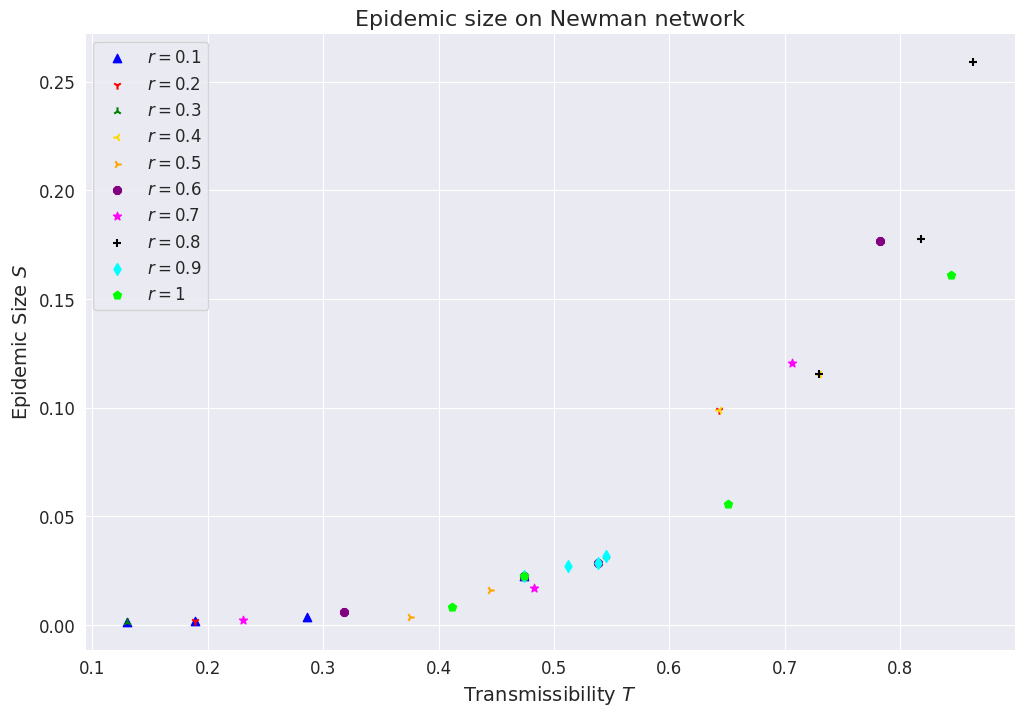

In [148]:
marker_style=["^","1","2","3","4","8","*","+", "d", "p"]
colors=["blue","red","green","gold","orange","purple","magenta","black","cyan", "lime"]

plt.figure( figsize=(12,8))

for i in range(len(betas)):
    S_temp_k10=[]
    T_temp_k10=[]
    for j in range(len(gammas)):
        S_temp_k10.append(S_k10[j*(i+1)])
        T_temp_k10.append(T_k10[j*(i+1)])
    plt.scatter(T_temp_k10,S_temp_k10, marker=marker_style[i], color=colors[i], label=(r"$r= $"+str(betas[i])))
plt.title("Epidemic size on Newman network")
plt.xlabel("Transmissibility $T$")
plt.ylabel("Epidemic Size $S$")
plt.legend()
plt.show()




In [153]:
T_k5=[]
S_k5=[]
kappa=5
for beta in tqdm(betas):
    for gamma in gammas:
        T_i=0
        S_i=0
        for i in range(num_sim):
            RES=simulation(beta,gamma,kappa,num_nodes)
            #T_i+=RES[0]
            S_i+=RES[1]
        #T_i /= num_sim
        T_i =RES[0]
        S_i /= num_sim
        T_k5.append(T_i)
        S_k5.append(S_i)

for i in range(len(S_k5)):
    S_k5[i] = S_k5[i]/num_nodes

T_k20=[]
S_k20=[]
kappa=20
for beta in tqdm(betas):
    for gamma in gammas:
        T_i=0
        S_i=0
        for i in range(num_sim):
            RES=simulation(beta,gamma,kappa,num_nodes)
            #T_i+=RES[0]
            S_i+=RES[1]
        #T_i /= num_sim
        T_i =RES[0]
        S_i /= num_sim
        T_k20.append(T_i)
        S_k20.append(S_i)

for i in range(len(S_k20)):
    S_k20[i] = S_k20[i]/num_nodes

100%|██████████| 10/10 [31:28<00:00, 188.90s/it]


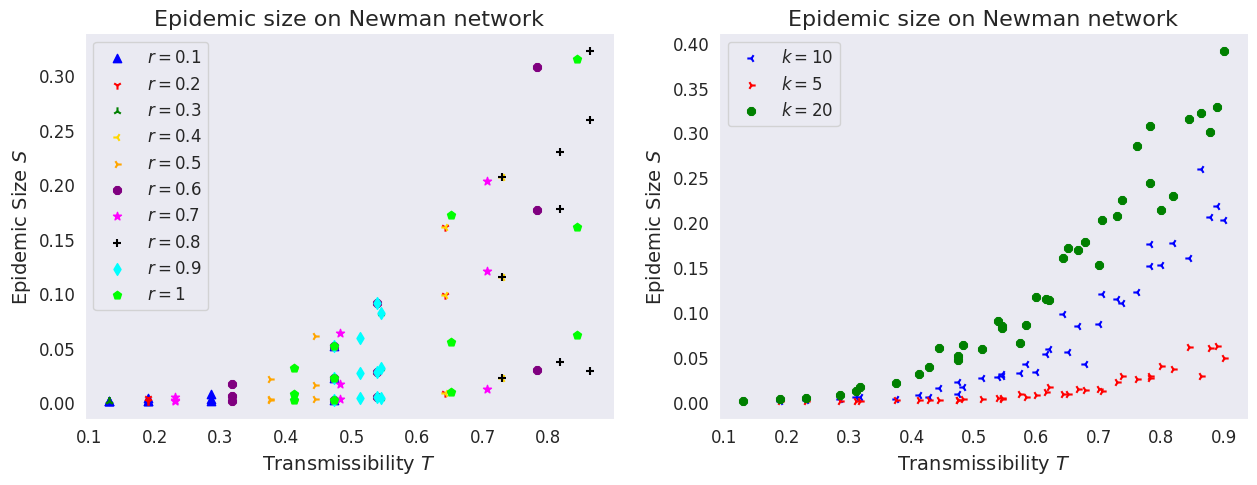

<Figure size 1200x800 with 0 Axes>

In [154]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))


marker_style=["^","1","2","3","4","8","*","+", "d", "p"]
colors=["blue","red","green","gold","orange","purple","magenta","black","cyan", "lime"]

plt.figure( figsize=(12,8))

for i in range(len(betas)):
    S_temp_k10=[]
    T_temp_k10=[]
    for j in range(len(gammas)):
        S_temp_k10.append(S_k10[j*(i+1)])
        T_temp_k10.append(T_k10[j*(i+1)])
    ax[0].scatter(T_temp_k10,S_temp_k10, marker=marker_style[i], color=colors[i], label=(r"$r= $"+str(betas[i])))

    S_temp_k5=[]
    T_temp_k5=[]
    for j in range(len(gammas)):
        S_temp_k5.append(S_k5[j*(i+1)])
        T_temp_k5.append(T_k5[j*(i+1)])
    ax[0].scatter(T_temp_k5,S_temp_k5, marker=marker_style[i], color=colors[i])

    S_temp_k20=[]
    T_temp_k20=[]
    for j in range(len(gammas)):
        S_temp_k20.append(S_k20[j*(i+1)])
        T_temp_k20.append(T_k20[j*(i+1)])
    ax[0].scatter(T_temp_k20,S_temp_k20, marker=marker_style[i], color=colors[i])



ax[1].scatter(T_k10,S_k10, marker="3", color="blue", label=(r"$k=10$"))
ax[1].scatter(T_k5,S_k5, marker="4", color="red", label=(r"$k=5$"))
ax[1].scatter(T_k20,S_k20, marker="8", color="green", label=(r"$k=20$"))

for ax in ax.flat:
    ax.grid()
    ax.set_title("Epidemic size on Newman network")
    ax.set_xlabel("Transmissibility $T$")
    ax.set_ylabel("Epidemic Size $S$")
    ax.legend()


plt.show()


from


















### Exercise 5.15
Approximately find the critical transmissibility $T_c$ for different values of $\kappa$ in yourr simulations, and compare your results to those of the manuscript. Are they similar? Since we are simulating a smaller system, we do not expect a perfect match, but we do expect a similar qualitative behaviouor.

The two graphs above depict the same simulation. On one side, I emphasize the dependence on the rate for each result, while on the other, I highlight the dependence on for the results. In particular, on the right graph, I plotted the trend of "Epidemic size" concerning transmissibility, distinguishing the three curves at different values of . The results I obtained are:

$ k=5 \rightarrow T=0.7 $

$ k=10 \rightarrow T=0.5 $

$ k=20 \rightarrow T=0.3$

Although the results are not in perfect agreement with the expected ones (I used fewer nodes and fewer repetitions for each model due to computational costs compared to the simulations described in the article), the numerical results I obtained correctly reflect the behaviors discussed in the article.

### Exercise 5.16
Explain why $T_c$ decreases when $\kappa$ is increased. How is this related to the presence of super-spreaders, and how do they impact the global epidemic dynamics?

The `get_newman_network` distribution used to extract node connections, or more precisely, to extract the degrees of each node, exhibits an exponential cutoff at degree $k$. This means that as $k$ increases, there are more possible contacts. For systems with the same transmissibility, the pandemic will spread more in the network with more contacts. Therefore, by increasing the contacts, a lower transmissibility is sufficient to make the pandemic grow. This is why the critical transmissibility $T_c$ decreases as $k$ increases.